# For Honor and Profit: Optimizing an NBA Franchise 

Thompson Bliss, tbliss@wisc.edu

Aaron Kelly, aaron.kelly@wisc.edu

Elizabeth Scaria, scaria@wisc.edu

## Table of Contents

1. <a href='#Preface'>Preface</a>
2. <a href='#Introduction'>Introduction</a>
<br>
3. <a href='#1'>Section 1: Player Valuation</a> <br>
    a. <a href='#1a'>Section 1a: K-Means Clustering</a>  
    b. <a href='#1b'>Section 1b: Random Salary Assignment</a>
    <br>
4. <a href='#2'>Section 2: Five Season Free Agency Plan</a> <br>
    a. <a href='#2a'>Section 2a: Free Agency Plan Results</a>   
    b. <a href='#2b'>Section 2b: Free Agency Plan Pareto Curves</a> <br>    
5. <a href='#3'>Section 3: Building a Stadium</a> <br>
    a. <a href='#3a'>Section 3a: Building a Stadium Results</a>  
    b. <a href='#3b'>Section 3b: Building a Stadium Pareto Curve</a> <br> 
    
7. <a href='#Conclusion'>Conclusion</a>
8. <a href='#Limitations'>Model Limitations</a>
9. <a href='#Footnote'>Appendix</a>

<a id='Preface'></a>
## Preface

In order to run this notebook, the following packages must be added:

* JuMP - provides a domain-specific modeling language for mathematical optimization embedded in Julia
* NamedArrays - implements a drop-in replacement of Array with named dimensions
* PyPlot - provides a Julia interface to the Matplotlib plotting library from Python
* KNITRO - provides an interface for using the Artelys Knitro solver from Julia. A free academic license can be obtained <a href='https://www.artelys.com/en/optimization-tools/knitro'>here</a>.
* Cbc - provides a Julia interface to a mixed-integer linear programming solver
* DataFrames - provides tools for working with tabular data in Julia

<a id='Introduction'></a>
## Introduction

Dear Mr. Robert Sarver and the Phoenix Suns Operations Research team,

On behalf of the employees of Bliss, Kelly, & Scaria (BK&S) we are happy to submit our firm’s proposal in response to the Phoenix Suns organization’s Request For Proposal (RFP) on how to make the Phoenix Suns a prominent team in the NBA. BK&S believes that the best way to do this is to create a winning team through the signing of free agents, and to build a new home stadium for the Suns. Building a stronger team will obviously improve the Suns’ profile, but our consultants at BK&S strongly believe that a brand new stadium designed to provide an exhilarating experience for Suns fans is nearly as important as the team itself; if you build it, they will come. 
    
In the post-Moneyball sports world, the use of data in making decisions regarding player signings has become nearly ubiquitous. The NBA in particular has greatly invested in data gathering methods to ensure that franchise analytics teams have plenty of high quality data to work with <a href='#Footnote'>[1]</a>. Teams such as the Golden State Warriors, who languished in the middle of the standings for many seasons, can partially credit their rise to the use of analytics <a href='#Footnote'>[2]</a>. In the modern NBA, failure to keep up with the ever-changing analytics field can ruin a franchise’s hopes of a championship.
    
 However, there is a significant difference between using analytics to make a good decision and making an optimal decision. An optimal decision accounts for the many constraints, such as player salary, positions on a team, and general franchise growth, that accompany and provide the context of any decision made in the NBA. Analytics is the pick, and optimization is the roll.
BK&S’s consultants are uniquely equipped to answer the optimization questions posed in your RFP, questions related to:

* What is the best way to determine NBA player value?

* What is the optimal strategy for recruiting NBA free agents over a five year period?

* What is the optimal strategy to grow the Suns franchise by investing in a new stadium?

This report consists of three sections. The first section deals with player valuation. The models in this section seek to understand the relationship, if one exists, between player productivity and salary. This section then proposes an alternate method of valuing players based on their productivity. The findings in this section are used to determine player salaries that will be used in the subsequent sections’ models.
    
The second portion of the report provides a simple model to recruit free agents over a five season period, according to constraints such as player availability, salary, playing position, among others.
    
The final section of the report seeks to solve the question of building a stadium within the next five years. This section looks for the optimal time at which to build this stadium and how much will need to be invested, while still maintaining a strong playoff-worthy team and minimizing financial loss. 
    
The analysis included in this proposal can be considered preliminary. All the models use public data from <a href='http://insider.espn.com/nba/hollinger/statistics'>ESPN</a>, <a href='http://www.spotrac.com/nba/contracts/'>Spotrac</a>, and <a href='http://www.dsg.com/jerseyreport/basketball/'>Dick's Sporting Goods</a>. If BK&S is awarded the contract with the Suns’, one of our first priorities would be to rerun our preliminary models with the Suns organization’s more accurate and expansive datasets of player metrics. BK&S also plans to, if awarded the contract, expand the work described in this proposal. A summary of potential future work is included in the conclusions section.

Note: all dollar values expressed in this paper are in millions.

<a id='1'></a>

## Section 1: Player Valuation

Loading data for the models:

In [1]:
using JuMP
using NamedArrays
using PyPlot
using KNITRO
using Cbc
using DataFrames

raw = readcsv("NBA.csv");
(m,n) = size(raw)

n_categories = 2:n     # columns containing categories
n_playername = 2:m     # rows containing player names

categories = raw[1,n_categories][:]            # the list of categories
playernames = raw[n_playername,1][:]           # the list of player names
positions = categories[1:5]                    # list of positions
seasons = categories[6:10]                     # list of seasons

# data[f,i] is the categories of player f listed in i
data = NamedArray( raw[n_playername,n_categories], (playernames,categories), 
    ("playernames","categories") );

The first model is used to propose a new way to value free agents. <a href='http://insider.espn.com/nba/hollinger/statistics'>ESPN</a> provides advanced stats including an estimate on the number of wins an individual player adds to his team, EWA. This stat encompasses many other player statistics such as points, rebounding, assists etc. Since players should be paid based on how much they help the team win, we feel that this is a good statistic to determine a player's worth. We plot current player salaries vs EWA for all 343 players in the NBA to see if there could be a relationship. The plot is seen below:

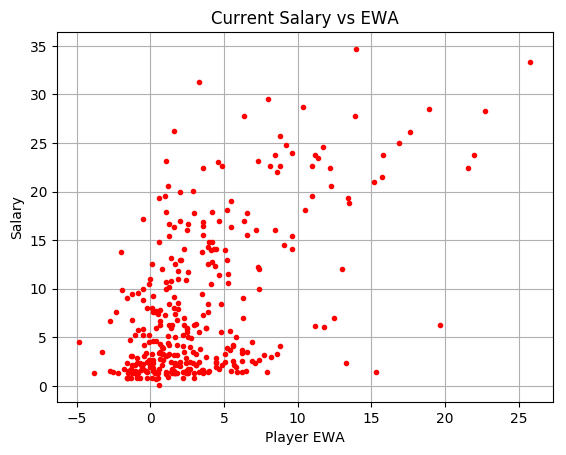

In [2]:
plot(data[:,"EWA"], data[:,"Salary"], "r.")
xlabel("Player EWA")
ylabel("Salary");
title("Current Salary vs EWA")
grid()

<a id='1a'></a>

### Section 1a: K-Means Clustering 

From the plot above, we can see that salary is not strongly correlated with EWA and is just about random with respect to player performance.

Given the randomness in player salaries, we propose a new way of determining player salaries by dividing players into paygrades.
We use a k-means cluster approach to separate players into four separate paygrade sets. This implementation of a k-means clustering algorithm is a mixed integer non-linear program (MINLP). The program determines which players belong to each of the three paygrades by minimizing the difference between an individual player’s EWA and the paygrade’s average EWA. The average EWA for each paygrade is determined by the program. We assign the players in the first (lowest) paygrade a random salary in \$1.4- 5 million; we assign the players in the second paygrade a random salary between \$5-15 million; we assign the players in the third paygrade a random salary between \$16- 27 million;we assign the players in the fourth (highest) paygrade a random salary between \$28-35 million. 

EWA is a vector composed of individual player EWAs.

The model components are as follow:

Assumptions:

* Compared to players of a similar productivity, a player’s salary is fairly random.


Decision variables:
* $\omega$: a 4 row by 37 column matrix of binary values indexed by paygrades (rows) and EWAs (columns). $\omega[Paygrade,\: EWA] = 1$ if the player's EWA belongs to this paygrade, and zero if he does not.

  $\omega_{ij}  \in \{0,1\}$


* d: a 4 row by 37 column matrix that represents the square of the 2-norm distance from a specific player's EWA to the average EWA of the paygrade to which he belongs. $d[Paygrade,\: EWA] =$ the 2-norm squared from a particular EWA value to the average EWA of its paygrade.

Constraints:
* All players must be included in a paygrade.
 
  $\sum_{j \: \in\: EWA} \omega_{ij} \: = \: 1$


* d, the 2-norm squared from the player's EWA to the average EWA of their paygrade, must be greater than or equal to the 2-norm squared of a given player and paygrade mean, $\mu _ {i}$, if the player is in the given paygrade.

  $(EWA_j - \mu_i)^2 \omega_{ij} \leq d_{ij}$


Objective:
* Minimize the sum of the 2-norm squared distance between each player’s EWA and the average EWA of his paygrade grouping.

  $\sum_{i\:\in\:paygrades} \: \sum_{j\:\in\:EWA} d_{ij}$
  

It is important to note that the KNITRO solver we have used is an academic-licensed version, which restricts the number of variables we can solve for in our model. We have solved our program for 37 randomized players to find the average EWA of each paygrade. We have then used those averages to sort the remaining players into appropriate paygrades. Our future work will involve running the k-means cluster program for the entire set of players if we are able to obtain a full license of KNITRO as the Suns organization’s consultants.
The model is written in standard form below:


\begin{equation*}
\begin{aligned}
& \underset{d,\:\omega}{\text{minimize}}
& & \sum_{i\:\in\:paygrades} \: \sum_{j\:\in\:EWA} d_{ij} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\\
\\
\\
& \text{subject to} \\ \\
\end{aligned}
\end{equation*}
\begin{alignat}{2}
    &(EWA_j - \mu_i)^2 \omega_{ij} \leq d_{ij}  
    && \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\forall \: i \: \in paygrades, \: j \: \in \: EWA \\ \\
    & \sum_{j \: \in\: EWA} \omega_{ij} \: = \: 1
    && \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\forall \: j\: \in \: EWA \\ \\
    &\omega_{ij}  \in \{0,1\}
\end{alignat}


<a href='#Footnote'>[3]</a> Note, parts of our model were inspired from a stackexchange answer.

In [3]:
#Setting Random Seed
srand(30);

#Setting Random Indices
randindices = rand(1:343,1,37);

#Saving the players and their associated random indices
randEWA = data[playernames[randindices], "EWA"];


m = Model(solver=KnitroSolver(outlev = 0))


num_clusers = 1:4
num_dataPoints = 1:37

#Binary variable, if data point j is in cluster i
@variable(m, w[num_clusers,num_dataPoints], Bin) 
#distance of data point from mean
@variable(m, d[num_clusers,num_dataPoints])      


#mean of cluster
@NLexpression(m, mean[i in num_clusers], sum(randEWA[j] * 
        w[i,j] for j in num_dataPoints)/sum(w[i,j] for j in num_dataPoints))

#distance of data point from mean must be greater than or equal to norm of difference 
#between mean and point
for i in num_clusers
    for j in num_dataPoints
      @NLconstraint(m, d[i,j] >= (randEWA[j] - mean[i])^2 * w[i,j])
    end
end

#each data point must be assigned to exactly 1 cluster
for j in num_dataPoints
   @constraint(m, sum(w[i,j] for i in num_clusers) == 1) 
end

#setting value for optimal solution
for i in num_clusers
    for j in num_dataPoints
        setvalue(w[i,j], 1)
    end
end

#minimize distance between data point and mean
@objective(m, Min, sum(d[i,j] for i in num_clusers, j in num_dataPoints))


solve(m);

<a id='1b'></a>


### Section 1b: Random Salary Assignment

From our K-means function we have four ‘means’ that represent logical categories of player skill. We filter through our list of players’ EWAs and reassign their salary based on which paygrade their EWA falls into. The following function compares the player’s EWA first to the paygrade 4 and paygrade 3. If the player is closer to paygrade 4 he will be assigned a random salary from that range. If the player is closer to paygrade 3 his EWA will then be compared to paygrade 2 and so on. 

The paygrades can be described as follows:

* Paygrade 4: True star players.
* Paygrade 3: Good enough to play as a starter and be paid as one.
* Paygrade 2: Likely a bench player.
* Paygrade 1: Not a strong player. Will likely earn the league minimum.

The resulting means from the K-means clustering are as follows:

In [4]:
means = [getvalue(mean[1]),getvalue(mean[2]),getvalue(mean[3]),getvalue(mean[4])];
means = sort(means);
print(means)

[-0.553846, 2.41667, 7.15, 14.375]

In [5]:
# Break salaries into buckets and assign random salary values within range
function randomSalaries(EWA)
    if abs(EWA - means[4]) <= abs(EWA - means[3])
        return rand(28:35, 1)[1]
    elseif abs(EWA - means[3]) <= abs(EWA - means[2])
        return rand(16:27, 1)[1]
    elseif abs(EWA - means[2]) <= abs(EWA - means[1])
        return rand(5:15, 1)[1]
    else
        return rand(1.4:5, 1)[1]
    end
end

# Overwrite salary data with random salaries
for i in playernames
    data[i,"Salary"] = randomSalaries(data[i,"EWA"])
end

Here is a graph of the newly assigned salaries and EWA:

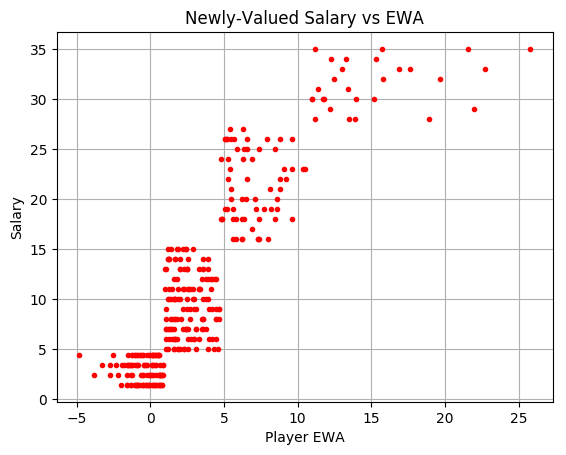

In [6]:
plot(data[:,"EWA"], data[:,"Salary"], "r.")
xlabel("Player EWA")
ylabel("Salary");
title("Newly-Valued Salary vs EWA")
grid()

As is shown above, the adjusted salaries are considerably more correlated with player EWA. This new salary assignment will allow the Suns management to make better decisions when deciding how much to pay a particular player.

<a id='2'></a>

## Section 2: Five Season Free Agency Plan

The second model is an assignment problem. In this model, we seek to determine the roster which will produce the greatest team-total EWA over five seasons. 

*Assumptions:*

* The only way a player can join our team is through free agency
* All free agent contracts last exactly three years
* Players will play at a single position for a particular season during their tenure with the Suns
* A player’s performance statistics (EWA, TS, REBR, etc.) and salary are static over the time horizon
* If we sign a player, he will play on our team (i.e. if he is included on our roster he will join our team)

*Decision variables:*
* X: a set of 5 matrices, each 343 rows by 5 columns, of all binary values. The value in $x_k$ at row $i$ and column $j$ will equal one if player $i$ is signed to the Suns and plays in position $j$ in year $k$. If player $i$ is not signed to the suns, the sum of row $i$ will be zero. One matrix exists for each of the five seasons under consideration.

 $x_{ijk}  \in \{0,1\}$



*Constraints:*
* Players can only play one position on a team for a given season.
    
  $\sum_{j\: \in \: positions} x_{ijk} \leq 1\hspace{10pt}\forall \: k \in \: seasons , \: \forall \: i \in \: players$


* Position: each team can have only two players signed to play a position (point guard, shooting guard, center, small forward, and power forward).

  $\sum_{i\: \in \:players} x_{ijk} = 2 \hspace{10pt} \forall k \: \in \: seasons, \forall \: j \in \: positions$
  

* Salary cap: The suns cannot spend over the league salary cap on player salaries in any season. We use \$95 million as the salary cap each season.

 $\sum_{j\: \in \:positions} x^{T} Salary \leq SalaryCap \hspace{10pt}  \forall \: k \: \in \: seasons$
  

* Current Suns players must stay on the team until they are eligible for free agency.

  $\sum_{j\: \in \:positions} x_{ijk} \geq Suns_{i} \hspace{10pt} \forall \: i \: \in  \: players, \: k = Year \: 1$  


* The only players on the team in year 1 are free agents or current Suns players.
  
  $\sum_{j\: \in \:positions} x_{ijk} \leq Suns_{i}+YearAvail_{ik} \hspace{10pt} \forall \: i \: \in  \: players, \: k = Year \:$ 1  
  
  
* The only players on the team are newly added free agents or players from a previous season.

  $\sum_{j\: \in \:positions} x_{ijk} \leq YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{10pt} \forall\: i\: \in\: players,\: k\: \in\: \{Year \: 1,\:Year\: 2,\:Year\:3,\:Year\:4\}$  
  
  
* Contract length: if a player is signed, he must remain on the team for at least 3 consecutive years.
  
  $\sum_{j\: \in \:positions} x_{ijk} \geq - YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{10pt}\: \forall \:i\: \in\: players,\: k \:\in\: \{Year\:1,\:Year\:2,\:Year\:3,\:Year\:4\}$  
  
  
* Play within positions: players can only play within the positions they are qualified to do so.

  $x_{ijk} \leq PlayerPos_{ij} \hspace{10pt} \forall k \in seasons, \: \forall \: j \: \in \: positions, \forall i \in players$
  
  
  

*Objective:*

* The objective maximizes the sum of the selected player statistic(s) over the course of the five season time horizon. This objective function is flexible and allows the decision maker to decide which player statistics for which they would like to optimize the team. The decision maker can decide the statistics they would like to maximize by varying $\lambda_i$ where i is the set of player statistics EWA, TS, AST, TO, REBR, and POP. A larger value of $\lambda_i$ will weight statistic $i$ as more important in the maximization function. The signs of each $\lambda_i$ represent if the statistic is helpful or detrimental for team success. We decided popularity should be negative because optimizing a team for popular players carries the risk of not being able to sign them because these players will likely have many team offers. If team management would like a higher team popularity, set $\lambda_{POP} < 0$

 $\underset{x}{\text{maximize}}\hspace{5pt} \\ {\large\lambda}_{EWA}\sum_{k\:\in \:seasons} x^{T}EWA\:+\:{\large\lambda}_{TS}\sum_{k\:\in \:seasons}x^{T}TS\:+\:{\large\lambda}_{AST}\sum_{k\:\in \:seasons}x^{T}AST \\ \\
 \:- \:{\large\lambda}_{TO}\sum_{k\:\in \:seasons}x^{T}TO\: +\:{\large\lambda}_{REBR}\sum_{k\:\in \:seasons}x^{T}REBR\:-\:{\large\lambda}_{POP}\sum_{k\:\in \:seasons}x^{T}POP$


The matrices/vectors involved in this program are:

Each of the following vectors contains the listed data values below for each player. 
* EWA  =  Expected Wins Added to a team’s season
* TS = Shooting percentage weighted with point values for free throws and 3-pointers
* TO = Percentage of possessions that end in a turnover
* AST = Percentage of possessions that end in an assist.
* REBR = Number of rebounds per 100 possessions.
* POP = Binary value; is one if player is in the top 50 selling jerseys, zero otherwise.
* Suns = Binary value; is 1 if player is a Suns player in the first year, zero otherwise
* Salary = adjusted salary set in Section 1


The model also uses the following matrices:
* PlayerPos = Matrix indexed by player name and position. PlayerPos["Player name","Position type"] is one if player is able to play that position and zero if not.
* YearAvail = Matrix indexed by player name and year. YearAvail["Player name","Year"] is one if player is available to sign that year and zero if not.



The program in standard form is represented by the following:

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{maximize}}
& & {\large\lambda}_{EWA}\sum_{k\:\in \:seasons} x^{T}EWA\:+\:{\large\lambda}_{TS}\sum_{k\:\in \:seasons}x^{T}TS\:+\:{\large\lambda}_{AST}\sum_{k\:\in \:seasons}x^{T}AST\:- \:{\large\lambda}_{TO}\sum_{k\:\in \:seasons}x^{T}TO\: \\ \\
& & & +\:{\large\lambda}_{REBR}\sum_{k\:\in \:seasons}x^{T}REBR\:-\:{\large\lambda}_{POP}\sum_{k\:\in \:seasons}x^{T}POP\\
\\
\\
& \text{subject to}
\end{aligned}
\end{equation*}
\begin{alignat}{2}
  &\sum_{j\: \in \: positions} x_{ijk} \leq 1
  &&\forall \: k \in \: seasons , \: \forall \: i \in \: players \\ \\
  &\sum_{i\: \in \:players} x_{ijk} = 2 \hspace{5pt} 
  &&\forall k \: \in \: seasons, \forall \: j \in \: positions  \\ \\
  &\sum_{j\: \in \:positions} x^{T} Salary \leq SalaryCap \hspace{5pt}  
  &&\forall \: k \: \in \: seasons\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \geq Suns_{i} \hspace{5pt} 
  &&\forall \: i \: \in  \: players, \: k = Year \: 1\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \leq Suns_{i}+YearAvail_{ik} \hspace{5pt} 
  &&\forall \: i \: \in  \: players, \: k = Year \: 1\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \leq YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{5pt} 
  &&\forall\: i\: \in\: players,\: k\: \in\: \{Year \: 1,\:Year\: 2,\:Year\:3,\:Year\:4\}\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \geq - YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{5pt}\: 
  &&\forall \:i\: \in\: players,\: k \:\in\: \{Year\:1,\:Year\:2,\:Year\:3,\:Year\:4\}\\ \\
  &x_{ijk} \leq PlayerPos_{ij} \hspace{5pt}   
  &&\forall k \in seasons, \: \forall \: j \: \in \: positions, \forall i \in players \\ \\
  &x_{ijk}  \in \{0,1\}
\end{alignat}

In [7]:
#EWA_param = tradeoff paramter for EWA
#TS_param = tradeoff paramter for True Shooting Percentage
#AST_param = tradeoff paramter for Assist Ratio
#TO_param = tradeoff paramter for Turnover Ratio
#REBR_param = tradeoff paramter for Rebound Rate
#POP_param = tradeoff paramter for Popularity

function fiveSeasons(EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

    cap = 95

    m = Model(solver=CbcSolver())
    
    #Player i, playing position j, during season k
    @variable(m, x[playernames, positions, seasons], Bin)

    # Each player can be signed once
    @constraint(m, a[i in playernames, k in seasons], sum(x[i,j,k] for j in positions) <= 1 )

    # each position has exactly two players
    @constraint(m, b[j in positions, k in seasons], sum(x[i,j,k] for i in playernames) == 2 )

    # Players can only play their positions
    @constraint(m, c[j in positions, i in playernames, k in seasons], x[i,j,k] <= data[i,j])

    # Team must stay under salary cap
    @constraint(m, d[k in seasons], sum(data[i, "Salary"]*x[i,j,k] for j in positions, i in 
                playernames) <= cap)

    # Current Sun players must stay on team
    # Anywhere Sun is equal to 1 must be on team
    @constraint(m, e[i in playernames], sum(x[i,j,"Year 1"] for j in positions) 
        >= data[i, "SUNS"])

    # Only add players available in year one
    @constraint(m, f[i in playernames, "Year 1"], sum(x[i,j,"Year 1"] for j in positions) 
        <= data[i,"Year 1"] + data[i, "SUNS"])

    # Appropriate players for other years
    @constraint(m, g[i in playernames, k in 1:4], sum(x[i,j,seasons[k]] for j in positions) 
        <= data[i,seasons[k]] + sum(x[i,j,seasons[k+1]] for j in positions))

    # Contract length constraint, players must play for three consecutive years
    @constraint(m, h[i in playernames, k in 1:4], sum(x[i,j, seasons[k]] for j in positions) 
        >= sum(x[i,j,seasons[k+1]] for j in positions) - data[i, seasons[k]])

    
    # Expressions for each statistic
    @expression(m, EWA[k in seasons], sum( x[i,j,k]*data[i, "EWA"] for i in playernames, 
                j in positions))
    @expression(m, TS[k in seasons], sum( x[i,j,k]*data[i, "TS%"] for i in playernames, 
                j in positions))
    @expression(m, AST[k in seasons], sum( x[i,j,k]*data[i, "AST"] for i in playernames, 
                j in positions))
    @expression(m, TO[k in seasons], sum( x[i,j,k]*data[i, "TO"] for i in playernames, 
                j in positions))
    @expression(m, REBR[k in seasons], sum( x[i,j,k]*data[i, "REBR"] for i in playernames, 
                j in positions))
    @expression(m, POP[k in seasons], sum( x[i,j,k] * data[i, "POP"] for i in playernames, 
                j in positions))


    # Objective
    @objective(m, Max, EWA_param*sum(EWA) + TS_param*sum(TS) - TO_param*sum(TO) 
        + AST_param*sum(AST) + REBR_param*sum(REBR) - POP_param*sum(POP))

    # Display data
    solve(m)

    
    return getvalue(x)    
    
end;

In [8]:
#Converts a binary variable to a string either yes if == 1, no if == 0
function parseBinaryYesNo(bin)
   
    if round(bin) == 1
        return "Yes"
    else
        return "No"
    end
    
end;

In [9]:
#Prints the results from season k
#EWA_param = tradeoff paramter for EWA
#TS_param = tradeoff paramter for True Shooting Percentage
#AST_param = tradeoff paramter for Assist Ratio
#TO_param = tradeoff paramter for Turnover Ratio
#REBR_param = tradeoff paramter for Rebound Rate
#POP_param = tradeoff paramter for Popularity

function printFiveSeasons(k, EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)
    
    x = fiveSeasons(EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

    #Clearing Data Frame
    roster = 0
    
    #Creating Data Frame
    roster =  DataFrame(Position = [], Player = [], EWA = [], TrueShootingPercent = [], 
        TurnoverRatio = [], AssistRatio =[], ReboundRate =[], Popular =[], Salary =[]) 
    

    for j in positions 
        for i in playernames
            if round(sum(x[i,j,k])) == 1
                push!(roster, [j, i, data[i,"EWA"], data[i,"TS%"], data[i, "TO"], 
                        data[i,"AST"], data[i, "REBR"],
                    parseBinaryYesNo(data[i,"POP"]), data[i, "Salary"]])
            end
        end
    end
    
    push!(roster, ["N/A", "TOTAL", round(sum( x[i,j,k]*data[i, "EWA"] for i in playernames, 
                        j in positions),1), 
                round(sum( x[i,j,k]*data[i, "TS%"] for i in playernames, j in positions)/10,3),
                round(sum( x[i,j,k]*data[i, "TO"] for i in playernames, j in positions)/10,1),
                round(sum( x[i,j,k]*data[i, "AST"] for i in playernames, j in positions)/10,1),
                round(sum( x[i,j,k]*data[i, "REBR"] for i in playernames, 
                        j in positions)/10,1),
                sum( x[i,j,k] * data[i, "POP"] for i in playernames, j in positions),
                round(sum(data[i, "Salary"]*x[i,j,k] for j in positions, i in playernames),1)
            ])
    
    return roster
end;

<a id='2a'></a>

### Section 2a: Free Agency Plan Results

The following tables list the optimal roster for years 1 through 5 given the values of the optimization parameters.

Currently the parameters are set to only maximize EWA, however the team management should feel free to change the paramaters within the following code block to experiment with different combinations statistics to optimize.

In [10]:
EWA_param = 1;
TS_param = 0;
AST_param = 0;
TO_param = 0;
REBR_param = 0;
POP_param = 0;

In [11]:
println("Season 1")
roster = printFiveSeasons("Year 1",
    EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

Season 1


,Position,Player,EWA,TrueShootingPercent,TurnoverRatio,AssistRatio,ReboundRate,Popular,Salary
1,PG,Quinn Cook,0.6,0.564,14.1,30.5,6.1,No,1.4
2,PG,Yogi Ferrell,0.3,0.538,11.3,14.3,6.9,No,1.4
3,SG,Devin Booker,7.1,0.616,11.4,23.1,8.5,Yes,20
4,SG,JJ Redick,4.6,0.582,14.9,20.8,15.7,No,5
5,SF,TJ Warren,7.7,0.619,11.8,25.8,13.1,No,19
6,SF,Josh Jackson,1.2,0.603,9.7,15.8,16,No,14
7,PF,Jeff Green,3.1,0.544,7.4,9.6,5.9,No,5
8,PF,Tarik Black,0.8,0.614,14.8,15.5,12.5,No,1.4
9,C,Alex Len,5.6,0.588,9.5,10.6,9.2,No,19
10,C,Tyson Chandler,2.1,0.613,7.9,8.5,16.5,No,8


In [12]:
println("Season 2:")
roster = printFiveSeasons("Year 2",
    EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

Season 2:


,Position,Player,EWA,TrueShootingPercent,TurnoverRatio,AssistRatio,ReboundRate,Popular,Salary
1,PG,Devin Booker,7.1,0.616,11.4,23.1,8.5,Yes,20
2,PG,Isaiah Thomas,0.7,0.591,8.7,22,6.3,No,2.4
3,SG,JJ Redick,4.6,0.582,14.9,20.8,15.7,No,5
4,SG,Quinn Cook,0.6,0.564,14.1,30.5,6.1,No,1.4
5,SF,TJ Warren,7.7,0.619,11.8,25.8,13.1,No,19
6,SF,Josh Jackson,1.2,0.603,9.7,15.8,16,No,14
7,PF,Jeff Green,3.1,0.544,7.4,9.6,5.9,No,5
8,PF,Tarik Black,0.8,0.614,14.8,15.5,12.5,No,1.4
9,C,David West,4.5,0.578,12.8,25.5,10.5,No,9
10,C,Tyson Chandler,2.1,0.613,7.9,8.5,16.5,No,8


In [13]:
println("Season 3:")
roster = printFiveSeasons("Year 3",
    EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

Season 3:


,Position,Player,EWA,TrueShootingPercent,TurnoverRatio,AssistRatio,ReboundRate,Popular,Salary
1,PG,Isaiah Thomas,0.7,0.591,8.7,22,6.3,No,2.4
2,PG,Quinn Cook,0.6,0.564,14.1,30.5,6.1,No,1.4
3,SG,JJ Redick,4.6,0.582,14.9,20.8,15.7,No,5
4,SG,Justise Winslow,0.9,0.509,4.4,13.6,5.8,No,2.4
5,SF,LeBron James,25.8,0.57,6.4,8.6,14,Yes,35
6,SF,Jeff Green,3.1,0.544,7.4,9.6,5.9,No,5
7,PF,TJ Warren,7.7,0.619,11.8,25.8,13.1,No,19
8,PF,Josh Jackson,1.2,0.603,9.7,15.8,16,No,14
9,C,David West,4.5,0.578,12.8,25.5,10.5,No,9
10,C,Tarik Black,0.8,0.614,14.8,15.5,12.5,No,1.4


In [14]:
println("Season 4:")
roster = printFiveSeasons("Year 4", 
    EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

Season 4:


,Position,Player,EWA,TrueShootingPercent,TurnoverRatio,AssistRatio,ReboundRate,Popular,Salary
1,PG,Isaiah Thomas,0.7,0.591,8.7,22,6.3,No,2.4
2,PG,Quinn Cook,0.6,0.564,14.1,30.5,6.1,No,1.4
3,SG,JJ Redick,4.6,0.582,14.9,20.8,15.7,No,5
4,SG,Justise Winslow,0.9,0.509,4.4,13.6,5.8,No,2.4
5,SF,TJ Warren,7.7,0.619,11.8,25.8,13.1,No,19
6,SF,Jeff Green,3.1,0.544,7.4,9.6,5.9,No,5
7,PF,LeBron James,25.8,0.57,6.4,8.6,14,Yes,35
8,PF,Josh Jackson,1.2,0.603,9.7,15.8,16,No,14
9,C,David West,4.5,0.578,12.8,25.5,10.5,No,9
10,C,Tarik Black,0.8,0.614,14.8,15.5,12.5,No,1.4


In [15]:
println("Season 5:")
roster = printFiveSeasons("Year 5", 
    EWA_param, TS_param, AST_param, TO_param, REBR_param, POP_param)

Season 5:


,Position,Player,EWA,TrueShootingPercent,TurnoverRatio,AssistRatio,ReboundRate,Popular,Salary
1,PG,Isaiah Thomas,0.7,0.591,8.7,22,6.3,No,2.4
2,PG,Quinn Cook,0.6,0.564,14.1,30.5,6.1,No,1.4
3,SG,Justise Winslow,0.9,0.509,4.4,13.6,5.8,No,2.4
4,SG,Luke Kennard,0.7,0.54,7.5,10.5,7.7,No,1.4
5,SF,LeBron James,25.8,0.57,6.4,8.6,14,Yes,35
6,SF,TJ Warren,7.7,0.619,11.8,25.8,13.1,No,19
7,PF,Anthony Davis,22,0.576,10.6,15.5,8.7,Yes,29
8,PF,Channing Frye,0.5,0.539,10.4,24.6,6.4,No,1.4
9,C,Tarik Black,0.8,0.614,14.8,15.5,12.5,No,1.4
10,C,Cristiano Felicio,0.7,0.507,12.6,14.3,15.9,No,1.4


<a id='2b'></a>

### Section 2b: Free Agency Plan Pareto Curves

A common discussion in the NBA is whether it is better to have a team that plays together well and passes a great amount or if it is ideal to build a team with individual offensive talent. A team that passes a lot will have a high assist ratio (AST). Alternatively, a team with individual offensive talent may have a higher true shooting percentage (TS). To compare these two potential situations, we set up a pareto curve between assists ratio (AST) and true shooting percentage (TS) as seen below:

(Please note generating each curve takes two or three minutes of computational time as it runs the model 30 times)

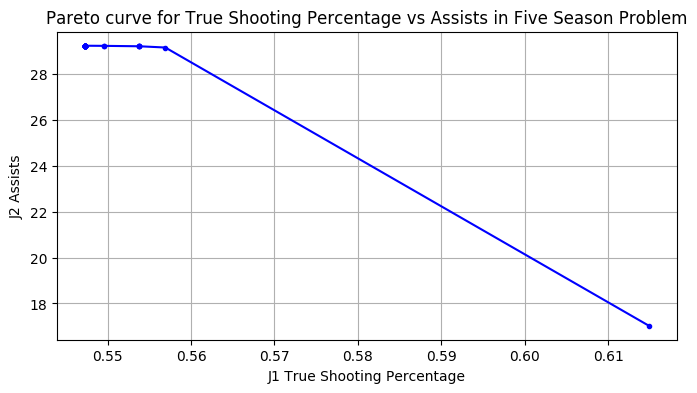

In [16]:
Npts = 30
J1 = zeros(Npts) #Tradeoff Parameter for True Shooting Percentage
J2 = zeros(Npts) #Tradeoff Parameter for Assist Ratio
for (l,λ) in enumerate(linspace(0,1,Npts))
    x = fiveSeasons(0, λ, 1-λ, 0, 0, 0)
    J1[l] = sum( x[i,j,k]*data[i, "TS%"] for i in playernames, j in positions, k in seasons)/50
    J2[l] = sum( x[i,j,k] * data[i, "AST"] for i in playernames, j in positions, k in seasons)/50
end;

figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel("J1 True Shooting Percentage")
ylabel("J2 Assists");
title("Pareto curve for True Shooting Percentage vs Assists in Five Season Problem")
grid()

These curves are normalized to represent the average player on the optimally chosen team. 

We can see from this curve that as predicted there is a negative correlation between the two quantities. Players who have a high AST ratio are more likely to have assists because they believe the team will have a better shot at scoring if they are to pass it than shooting themselves. On the other hand, players with a high TS will be more likely to shoot and not pass as they know they have a better chance of scoring themselves. It is likely that a team that maximizes assists will have a better balance of players that shoot well (when every team member assists, it implies all team members can shoot reliably). It is up to the team management to determine whether they would like to optimize for a team that is more assist or true shooting oriented. 
    
Another thing to consider is how well our team is able to keep possession of the ball. Players that have a high rebound ratio (REBR) are capable of gaining the team possession, while players with a high turnover ratio (TO) are more likely to lose team possession. We can form a similar trade off analysis, as seen below:

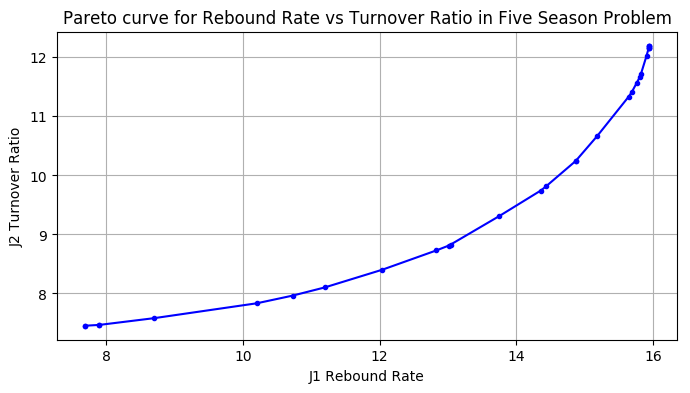

In [17]:
Npts = 30
J1 = zeros(Npts) 
J2 = zeros(Npts)
for (l,λ) in enumerate(linspace(0,1,Npts))
    x = fiveSeasons(0, 0, 0, λ, 1-λ, 0)
    J1[l] = sum( x[i,j,k]*data[i, "REBR"] for i in playernames, j in positions, k in seasons)/50
    J2[l] = sum( x[i,j,k]*data[i, "TO"] for i in playernames, j in positions, k in seasons)/50
end;

figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel("J1 Rebound Rate")
ylabel("J2 Turnover Ratio");
title("Pareto curve for Rebound Rate vs Turnover Ratio in Five Season Problem")
grid()

As you can see, there is a positive correlation between teams which collect a great amount of rebounds and teams that turn the ball often. When maximizing rebounds, the average player will turn the ball over four times less than he rebounds per 100 posessions. The primary reason to maximimze rebounding is to gain more posessions and according to this curve it is not particulary efficient in doing so as the player will also turn the ball over more about as much. 

Thus, maximizing rebounds will not help the team as much as it may seem. It is possible that when we build a team that maximizes rebound rates we are creating a team of players that more often plays in the paint under the hoop. Their proximity to the hoop would allow them to get more rebounds, but have more opportunities to turn the ball over given the crowded area they occupy. 

Again, it is up to team management to decide how to interpret these statistics, there is no one correct way to build a team.

<a id='3'></a>
## Section 3: Building a Stadium

Our final model is a combination of the previously described assignment problem and a network flow model in which we seek to find the optimal one-time investment the Suns need to create a winning team and expand their profile with a new stadium. This problem builds off the assignment problem in Section 2 by including more of the Suns financial context.

A diagram illustrating the concept of this model is shown below:

![](Investment.png)

In addition to the assumptions, decision variables, and constraints from the Section 2, this model contains the following additions.

*Assumptions:*
* Any profit taken from the team cannot be invested back into the team at a later time.
* When a stadium is built, it is paid for in the same year it is built, but the team does not receive and revenue from the stadium until the next year.
* Any investment in the team can come only from the owner. This ignores the role of the league and cities in finacially sustaining a team.

*Decision variables:*
* Profit (p): a sink associated with each season that represents any profit removed from the team. Profit is discounted according to its present value at the beginning of season, using the present value formula: $PV =  \frac{P_{Year \: k}}{(1+0.07)^{k}}$. Therefore, any profits accrued later in the five year period are worth less to the Suns presently than profits accrued earlier in the five year period.

  $p_k \geq 0 \hspace{10pt} \forall k \in seasons$



* Hold (h): a vector that represents the amount of money transferred from one season to the next. This is different from Profit because the 'hold' is cash that remains within the Suns organization. 

  $h_k \geq 0 \hspace{10pt} \forall k \in seasons$



* Stadium build (S): a 5 element vector of binary decision variables that takes the value of 1 if the new stadium is built (and paid for) during its corresponding season. This variable will take the value 0 if the stadium is not built during the corresponding season.

 $S_k \in \{0,1\} \hspace{10pt} \forall k \in seasons$



* Initial investment (I): a scalar that represents the one-time investment that must be made to accomplish the team's goals over the time horizon. We cap this investment at \$400 million because this is the net worth owner Robert Sarver.

 $0 \leq I \leq 400$


*Constraints:*
* Conservation of resources: the sum of money flowing into a season must equal the sum of money flowing out of a season. This constraint for Year 1 is different from the constraints for the subsequent years because of the initial investment and therefore must be written separately. "Upgrade cost" is the cost to build the stadium and must be paid in the same season the stadium is built.

\begin{equation}
  I\: = \: x^{T}Salary_1 + h_1 + p_1 + UpgradeCost * S_1 \hspace{10pt}k \: = \: Year\:1 \\ \\ \\
  70+h_{k-1} + 30\sum_{n=2}^{k}SV_{n-1}+15x^{T}POP  \hspace{10pt}\forall \: k\in\: \{Year\:2,\:Year\:3,\:Year\:4\,\:Year\:5\}
\end{equation}

* The stadium must be built during one of the five seasons.

  $$\sum_{k\:\in\:seasons}Stadium_k = 1$$

*Objective:*
* The objective function maximizes the total team EWA over the five season time horizon, while trading off for the basic return on investment (total profit - initial investment). Like the objective function in the assignment problem, this objective function also allows the decision maker to decide how much to weight maximizing EWA or return. 

  $\underset{x}{\text{maximize}} \hspace{10pt} \bigg(1-{\large\lambda_{loss}}\bigg)\sum_{k\:\in\:seasons}x^{T}EWA \: + \:\bigg\lbrack\bigg(\sum_{k\:\in\:seasons}pv\bigg) - I\bigg\rbrack{\large\lambda_{loss}}$

The model is written in standard form below:

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{maximize}}
& & \bigg(1-{\large\lambda_{loss}}\bigg)\sum_{k\:\in\:seasons}x^{T}EWA \: + \:\bigg\lbrack\bigg(\sum_{k\:\in\:seasons}pv\bigg) - I\bigg\rbrack{\large\lambda_{loss}}
\\
\\
\\
& \text{subject to}
\end{aligned}
\end{equation*}
\begin{alignat}{2}
  &\sum_{j\: \in \: positions} x_{ijk} \leq 1
  &&\forall \: k \in \: seasons , \: \forall \: i \in \: players \\ \\
  &\sum_{i\: \in \:players} x_{ijk} = 2 \hspace{5pt} 
  &&\forall k \: \in \: seasons, \forall \: j \in \: positions  \\ \\
  &\sum_{j\: \in \:positions} x^{T} Salary \leq SalaryCap \hspace{5pt}  
  &&\forall \: k \: \in \: seasons\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \leq Suns_{i}+YearAvail_{ik} \hspace{5pt} 
  &&\forall \: i \: \in  \: players, \: k = Year \: 1\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \leq YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{5pt} 
  &&\forall\: i\: \in\: players,\: k\: \in\: \{Year \: 1,\:Year\: 2,\:Year\:3,\:Year\:4\}\\ \\
  &\sum_{j\: \in \:positions} x_{ijk} \geq - YearAvail_{ik}+\sum_{j\: \in \:positions} x_{ijk+1} \hspace{5pt}\: 
  &&\forall \:i\: \in\: players,\: k \:\in\: \{Year\:1,\:Year\:2,\:Year\:3,\:Year\:4\}\\ \\
  &x_{ijk} \leq PlayerPos_{ij} \hspace{5pt}   
  &&\forall k \in seasons, \: \forall \: j \: \in \: positions, \forall i \in players \\ \\
  &I\: = \: x^{T}Salary_1 + h_1 + p_1 + UpgradeCost * S_1
  && \: k \: = \: Year\:1 \\ \\
  &70+h_{k-1} + 30\sum_{n=2}^{k}SV_{n-1}+15x^{T}POP
  &&\forall \:k\in\: \{Year\:2,\:Year\:3,\:Year\:4\,\:Year\:5\}\\ \\ 
  & \sum_{k\:\in\:seasons}Stadium_k = 1\\ \\
  &x_{ijk}  \in \{0,1\}\\ \\
  &0 \leq I \leq 400\\ \\
  &h_k \geq 0, p_k \geq 0, h_k \geq 0
  &&\forall \: k \in \: seasons \\ \\
  &S_k \in \{0,1\}
  &&\forall \: k \in \: seasons 
\end{alignat}

In [18]:
function stadiumBuild(loss_param) # Maximize EWA vs sava initial investment
    
    stadium_upgrade = 200 #Cost of Stadium upgrae
    cap = 95 #NBA Cap
    r = 1.07 #Present value of currency rate

    m = Model(solver=CbcSolver())

    
    @variable(m, x[playernames, positions, seasons], Bin) #Player matrix
    @variable(m, hold[seasons] >= 0) #Holdover until next year
    @variable(m, p[seasons] >= 0) #Yearly profit
    @variable(m, stadium[seasons], Bin) #Whether or not stadium is built in year k
    @variable(m, 0<= initial_investment <=400) # Owners potential investment

      
    # Profit exp
    @expression(m, salary[k in seasons], sum(data[i, "Salary"]*x[i,j,k] for j in positions, i in playernames))
    @expression(m, EWA[k in seasons], sum( x[i,j,k]*data[i, "EWA"] for i in playernames, j in positions))
    @expression(m, TS[k in seasons], sum( x[i,j,k]*data[i, "TS%"] for i in playernames, j in positions))
    @expression(m, AST[k in seasons], sum( x[i,j,k]*data[i, "AST"] for i in playernames, j in positions))
    @expression(m, TO[k in seasons], sum( x[i,j,k]*data[i, "TO"] for i in playernames, j in positions))
    @expression(m, REBR[k in seasons], sum( x[i,j,k]*data[i, "REBR"] for i in playernames, j in positions)) 
    @expression(m, Merch[k in seasons], 15*sum( x[i,j,k] * data[i, "POP"] for i in playernames, j in positions))
    @expression(m, pv_profit[k in 1:5], p[seasons[k]]/r^(k-1))  # present value profit
    @expression(m, svalue_added[k in 1:5], sum(30*stadium[seasons[k]]))
 
    
    # Each player can be signed once
    @constraint(m, a[i in playernames, k in seasons], sum(x[i,j,k] for j in positions) <= 1 )

    # each position has exactly two players
    @constraint(m, b[j in positions, k in seasons], sum(x[i,j,k] for i in playernames) == 2 )

    # Players can only play their positions
    @constraint(m, c[j in positions, i in playernames, k in seasons], x[i,j,k] <= data[i,j])

    # Team must stay under salary cap
    @constraint(m, d[k in seasons], sum(data[i, "Salary"]*x[i,j,k] for j in positions, i in playernames) <= cap)

    # Current Sun players start on team
    # Anywhere Sun is equal to 1 must be on team
    @constraint(m, e[i in playernames], sum(x[i,j,"Year 1"] for j in positions) >= data[i, "SUNS"])

    # Only add players available in year one
    @constraint(m, f[i in playernames, "Year 1"], sum(x[i,j,"Year 1"] for j in positions) <= 
        data[i,"Year 1"] + data[i, "SUNS"])

    # Appropriate players for other years
    @constraint(m, g[i in playernames, k in 1:4], sum(x[i,j,seasons[k]] for j in positions) <= 
        data[i,seasons[k]] + sum(x[i,j,seasons[k+1]] for j in positions))

    # Contract length constraint, players must play for three consecutive years
    @constraint(m, h[i in playernames, k in 1:4], sum(x[i,j, seasons[k]] for j in positions) >=
        sum(x[i,j,seasons[k+1]] for j in positions) - data[i, seasons[k]])



    # Financial Constraints

    # Year 1
    @constraint(m, initial_investment == salary["Year 1"] + hold["Year 1"] + p["Year 1"] 
        + stadium_upgrade*stadium["Year 1"])

    # Years 2 - 4
    # 70 is from ticket sales
    @constraint(m, l[k in 2:5], 70 + hold[seasons[k-1]] + sum(svalue_added[n-1] for n in 2:k) + Merch[seasons[k-1]]  
        == salary[seasons[k]] + hold[seasons[k]] + p[seasons[k]] + stadium_upgrade*stadium[seasons[k]])

    # Must build stadium
    @constraint(m, sum(stadium) == 1)


    # Objective
    # Max of Profit:
    @objective(m, Max, (1-loss_param)*sum(EWA) + (sum(pv_profit) - initial_investment)*loss_param)
    # Display data
    solve(m)

 
    
    return (getvalue(x), getvalue(hold), getvalue(p), getvalue(stadium), getvalue(initial_investment))    
    
end;


In [19]:
#Helps print data correctly
function isSeason1(k)
    if k == 1
        return 0
    else
        return 1
    end
end


#Prints EWA, and financial data for five seasons
function printStadiumBuild(loss_param)
    r = 1.07 #Present value of currency rate
    (x, hold, p, stadium, initial_investment) = stadiumBuild(loss_param)
    
    println("Initial Investment: ", initial_investment)
    
    #Clear Data Frame
    finacnialData = 0
    
    #Create Data Frame
    financialData =  DataFrame(Season = [], EWA = [], Holdover = [], PresentValueProfit = [],
                StadiumUpgrade =[], StadiumValueAdded =[], MerchandiceSales =[], SalarySpending =[]) 
    count = 1
    
    for k in 1:5        
        push!(financialData, [seasons[k], round(sum( x[i,j,seasons[k]]*data[i, "EWA"] for i in playernames, 
                            j in positions),1),
        round(hold[seasons[k]],2), round(p[seasons[k]]/r^(count-1),2), parseBinaryYesNo(stadium[seasons[k]]), 
            round(30*sum(stadium[seasons[n]]for n in 1:k)*isSeason1(k),2), 15*sum( x[i,j,seasons[k]] 
                    * data[i, "POP"] for i in playernames, j in positions),  round(sum(data[i, "Salary"]
                        *x[i,j,seasons[k]] for j in positions, i in playernames),2)])
    
        count = count + 1
    end
    
    return financialData
end;

<a id='3a'></a>
### Section 3a: Building a Stadium Results

Here, we have printed EWA and the financial data for the five year period. In the first model, we adjust the trade-off to purely maximize EWA while maintaining the available salary to pay for a stadium.


Currently the strategies tested are as follows:
trial_1 - Maximize EWA without regard to profit.
trial_2 - Maximize EWA and profit equally.
trial_3 - Maximize profit without regard to EWA.

Again the team management should feel free to change the paramaters within the following code block to compare decision strategies side by side. 

In [20]:
trial_1 = 0; 
trial_2 = .5;
trial_3 = 1;

In [21]:
printStadiumBuild(trial_1)

Initial Investment: 

,Season,EWA,Holdover,PresentValueProfit,StadiumUpgrade,StadiumValueAdded,MerchandiceSales,SalarySpending
1,Year 1,33.1,219.4,0.0,No,0.0,15.0,94.2
2,Year 2,32.4,219.2,0.0,No,0.0,15.0,85.2
3,Year 3,49.9,209.6,0.0,No,0.0,15.0,94.6
4,Year 4,49.9,0.0,0.0,Yes,30.0,15.0,94.6
5,Year 5,60.4,20.2,0.0,No,30.0,30.0,94.8


313.5999999999999


In [22]:
printStadiumBuild(trial_2)

Initial Investment: 290.6


,Season,EWA,Holdover,PresentValueProfit,StadiumUpgrade,StadiumValueAdded,MerchandiceSales,SalarySpending
1,Year 1,30.5,0.0,0.0,Yes,0.0,15.0,90.6
2,Year 2,25.2,0.0,39.25,No,30.0,15.0,73.0
3,Year 3,42.6,0.0,29.35,No,30.0,15.0,81.4
4,Year 4,42.6,0.0,27.43,No,30.0,15.0,81.4
5,Year 5,42.6,0.0,35.25,No,30.0,15.0,68.8


In [23]:
printStadiumBuild(trial_3)

Initial Investment: 286.99999999999994


,Season,EWA,Holdover,PresentValueProfit,StadiumUpgrade,StadiumValueAdded,MerchandiceSales,SalarySpending
1,Year 1,25.8,0.0,0.0,Yes,0.0,15.0,87.0
2,Year 2,20.7,0.0,42.62,No,30.0,15.0,69.4
3,Year 3,11.4,0.0,61.84,No,30.0,0.0,44.2
4,Year 4,11.4,0.0,45.55,No,30.0,0.0,44.2
5,Year 5,11.6,0.0,52.18,No,30.0,0.0,31.6


<a id='3b'></a>
### Section 3b: Building a Stadium Pareto Curve

This model naturally raises the question: how much does one need to invest in a team to obtain a winning team and a new stadium? Since the model requires the stadium be built, this question is really only about the relationship between the investment return and the team’s EWA over five years. We can understand this relationship with another tradeoff analysis. The results of this analysis are seen below:

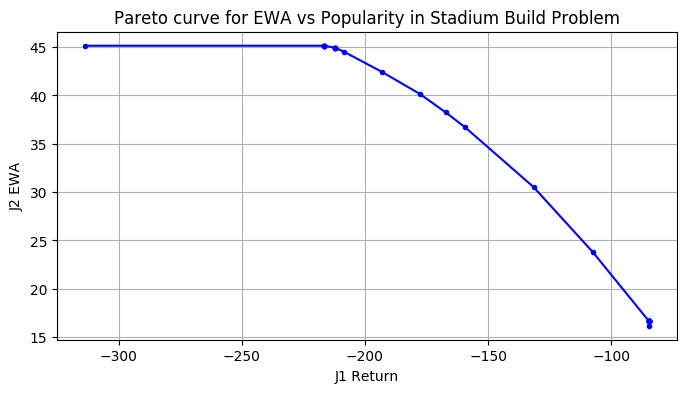

In [24]:
r = 1.07 #Present value of currency rate

Npts = 30
J1 = zeros(Npts) #Tradeoff Parameter for profit gained
J2 = zeros(Npts) #Tradeoff Parameter for EWA
for (l,λ) in enumerate(linspace(0,1,Npts))
    (x, hold, p, stadium, initial_investment) = stadiumBuild(λ)
    J1[l] = sum(p[seasons[k]]/r^(k-1) for k in 1:5) - initial_investment
    J2[l] = sum( x[i,j,k] * data[i, "EWA"] for i in playernames, j in positions, k in seasons)/5
end;

figure(figsize=(8,4))
plot( J1, J2, "b.-" )
xlabel("J1 Return")
ylabel("J2 EWA");
title("Pareto curve for EWA vs Popularity in Stadium Build Problem")
grid()

Here J1 Return is the total profit over the five year period minus the initial investment. This is essentially the amount of money from the initial investment that remains with the team and is not removed as profit. This return or loss is defined from the owner's perspective.

From this chart, we can see that the organization will always lose money within the five year time horizon. However, the organization can lose less money if they sign players that have lower EWAs and salaries and therefore can pull more money out of the team as profit. In theory, a team that has more popular and high EWA players will have more merchandise revenue. This is likely why the first part of the pareto curve is flat; we shift towards signing more popular players that give higher merchandise revenue that helps offset their high salary, thereby allowing us to increase our return. 

However, after this it is hard to win games if you are unwilling to pay your players a competitive salary.

The team recieves diminishing returns on EWA for each additional dollar invested into the team by the owner. Perhaps the best decision with regards to optimizing EWA is to take an approximatly \$220 million loss. Any further investment does not significantly affect the team EWA. This is likely due to the result of the salary cap. If none existed we might see EWA continuously increase with increased investment.

<a id='Limitations'></a>
## Model Limitations

While we believe that while the models presented provide interesting insights to develop the Suns, they do have limitations.

One limitation of these models is that they rely heavily on the accuracy of the data. Since all of our data for player statistics are point estimates, they have no notion of uncertainty or variance. If a data point deviates from its point estimate, that point can dramatically alter our set of feasible solutions, which affects the optimal solution. 

The optimization models presented in this report are deterministic and will produce the same solution(s) for a set of parameters. However, this is not always reflective of reality. In reality, the systems described in this model have some element of stochasticity/randomness. This randomness vary in how it manifests in the system, from players going on a 'hot streak,' to national or global macroeconomic factors affecting the financial health of the team. This example is dramatic, but it points out the degree to which events that could occur can dramatically alter our optimal decisions.

Another limitation of the models, particularly the model in Section 3, is that they do not fully capture the full complexity of financially supporting a team. For example, we assume that a team's merchandise revenue is linearly related to it's players' popularity. However, this is likely not the case, given the complexity of consumer economics.

<a id='Conclusion'></a>
## Conclusion

If awarded this contract, BK&S has several ideas for future work:

* We would like to rerun our models with the Suns official team data sets to ensure our results correspond to the most accurate data available.  


* We would like to run our k-means clustering MINLP with a full KNITRO solver license for all players  in the league instead of our random set to more accurately determine their paygrade. 


* We would also like to expand our network flow and assignment models to capture more of the nuances of team ownership and management. Currently our models highly simplify the complications in NBA cap and contract rules and are unable to take advantage of the nuances of these policies.


* We would like to address the shortcomings of our models as relating to talent evaluation, ability changes over player careers.


* We would like to construct more advanced merchandise and popularity models to more accurately reflect the relationship of these metrics to revenue. 


* We would like to add the concept of player time to our model.

For instance, a brief plan to implement our last point is the following:

Since different players on a team have different productivity, it is important to consider how much playing time each player on the roster should get. However, it is important that the players with the most productivity are not constantly playing for each game and have adequate breaks (during games and between games).  We could consider this as a scheduling problem, with 82 games that we need to schedule players for, and the sum of each player’s playing time in each game must equal the length of the game. This problem would have constraints related to how many minutes in a game a player can be on the court, how many games back to back in which he can play over a certain number of minutes, among others. This type of problem would require close collaboration with the coaching staff and could help reduce the injury rate of Suns players.


We at BK&S are confident that our models will be indispensable to the Suns organization as the Suns prepare to improve their eminence in the NBA. We have demonstrated a new way of valuing players that cuts through the randomness that accompanies player salaries using a MINLP to find the optimal paygrades for players. We have also demonstrated how to optimize a team roster for various player statistics over a five year horizon. Finally, we have shown differing investment strategies for building a new stadium within the next five years. 

We hope our project proposal meets the needs of the Suns organization. We look forward to the possiblity of firmly establishing the Phoenix Suns in a place of respect around the league.

Sincerely,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B, K, & S Consulting







## Appendix

<a id='Footnote'></a>

[1] CHANGING THE GAME: The Rise of Sports Analytics. (n.d.). Retrieved May 6, 2018, from https://www.forbes.com/sites/leighsteinberg/2015/08/18/changing-the-game-the-rise-of-sports-analytics/#761010184c1f

[2] Data analytics have revolutionized the NBA — Quartz. (n.d.). Retrieved May 6, 2018, from https://qz.com/1104922/data-analytics-have-revolutionized-the-nba/

[3] How can K-Means be Reduced to Integer Programming. (Febuary 15, 2016). Retrieved May 6, 2018, from https://cs.stackexchange.com/questions/29638/how-can-k-means-be-reduced-to-integer-programming